There's a large error in the contorl mid block.
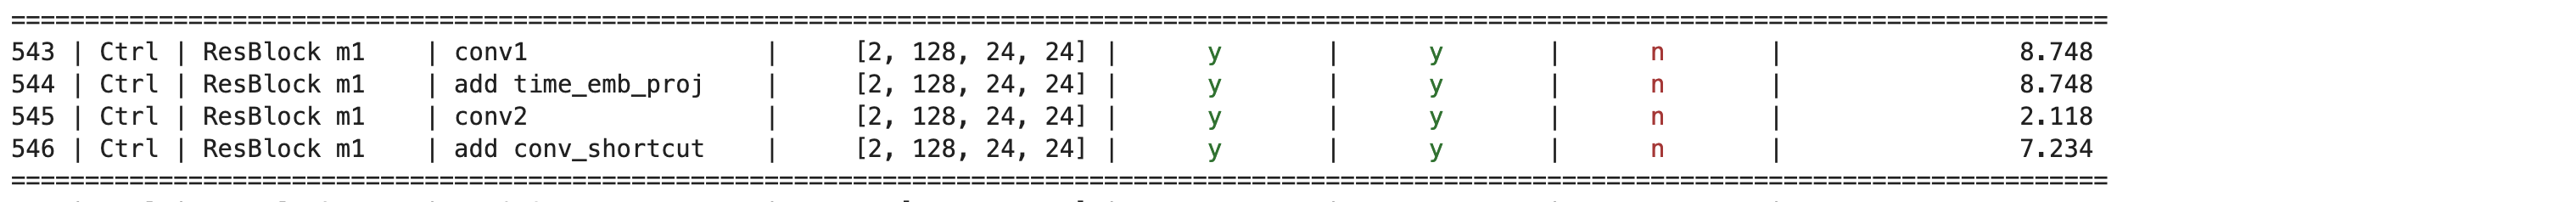
Let's analyze that.

**Edit: Solution:** I didn't apply the zero_conv on h_base before concatting it to ctrl mid. It's fixed now.

**Now all errors are gone!!**

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3, sci_mode=False)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load logs

In [3]:
from diffusers.umer_debug_logger import UmerDebugLogger

In [4]:
cloud_cuda = UmerDebugLogger.load_log_objects_from_dir('logs/cloud')
local_cuda = UmerDebugLogger.load_log_objects_from_dir('logs/local_cuda')

In [5]:
len(cloud_cuda), len(local_cuda)

(73, 73)

In [6]:
for i, (c,l) in enumerate(zip(cloud_cuda, local_cuda)):
    if c.msg!=l.msg: print(f'{i:<3}{c.msg:>20}{l.msg:>20}')

## Compare intermediate results

In [7]:
def mae(t1,t2):
    assert t1.shape==t2.shape
    return (t1-t2).abs().mean()

In [8]:
from functools import partial
from util_inspect import fmt_bool

def compare_intermediate_results(n=None,n_start=0,prec=5, compare_prec=3, ignore_base=False):
    if n is None: n=max(len(cloud_cuda), len(local_cuda))

    print(f'{"":<3} | {"block":<20} | {"shape":<20} | {"same names?":<12} | {"same shapes?":<12} | {"same values?":<12} | {"Δ cuda local -> cloud":<20}')
    print(f'{"":<3} | {"":<20} | {"":<20} | {"":<12} | {"":<12} | {"prec="+str(compare_prec):^12} | {"prec="+str(prec):^20}')

    def calc_total_len(lens): return sum(lens)+3*len(lens)-1
    total_len = calc_total_len((3,20,20,12,12,12,20))

    line = partial(
        lambda txt, width: print(txt * (width//len(txt))),
        width=total_len
    )
    
    labels = []
    def add_label(lbs, ctrl=True):
        if not isinstance(lbs, (list, tuple)): lbs = [lbs]
        for l in lbs:
            labels.append(('Base',l))
        for l in lbs: 
            if ctrl: labels.append(('Ctrl',l))
    
    # # to separate logs into sections
    lines_at = [5]                                     # input 
    def add_line_after(x): lines_at.append(lines_at[-1]+x)
    add_line_after(4)                                  # conv in
    for _ in range(8): add_line_after(4)               # enc       (R,R,D / RA,RA,D / RA,RA)
    add_line_after(4)                                  # mid
    for _ in range(9): add_line_after(3)               # dec       (RA,RA,RAU / RA,RA,RAU / R,R,R)
    fat_lines_at = [5,9,41,45,72]
    
    # # to describe each log line
    descrs = ['x', 'time info', 'text info', 'guidance image', 'guidance imagen (projected)']                              # input 
    descrs += ['base conv in','ctrl conv in','add guided hint to ctrl','add ctrl->base']                                   # conv in
    for _ in range(8):descrs += ['concat base -> ctrl','apply base block','apply ctrl block','add ctrl -> base']           # enc
    descrs += ['concat base -> ctrl', 'apply base block','apply ctrl block','add ctrl->base']                              # mid
    for _ in range(9): descrs += ['add ctrl encoder->base decoder','concat base encoder->base decoder','apply base block'] # dec 
    descrs += ['base conv out'] 
    
    line('#')
    for i in range(n_start,n):
        cc,lc = cloud_cuda[i], local_cuda[i]
                
        eq_name = cc.msg==lc.msg
        eq_shape = cc.shape==lc.shape
        eq_vals = torch.allclose(cc.t,lc.t,atol=10**-compare_prec)

        mae_2 = mae(lc.t,cc.t)        
        mae_2 = ("{:>20."+str(prec)+"f}").format(mae_2)
        
        print(f'{i+1:<3} | {cc.msg:<20} | {cc.shape:>20} | {fmt_bool(eq_name, "^12")} | {fmt_bool(eq_shape, "^12")} | {fmt_bool(eq_vals, "^12")} | {mae_2}\t{descrs[i]}')

        if i+1 in fat_lines_at: line('=')
        elif i+1 in lines_at: line('-')

In [9]:
compare_intermediate_results(compare_prec=3, prec=3, ignore_base=True)

    | block                | shape                | same names?  | same shapes? | same values? | Δ cuda local -> cloud
    |                      |                      |              |              |    prec=3    |        prec=3       
#######################################################################################################################
1   | prep.x               |       [2, 4, 96, 96] |      y       |      y       |      y       |                0.000	x
2   | prep.temb            |            [2, 1280] |      y       |      y       |      y       |                0.000	time info
3   | prep.context         |        [2, 77, 2048] |      y       |      y       |      n       |                0.001	text info
4   | prep.raw_hint        |     [2, 3, 768, 768] |      y       |      y       |      y       |                0.000	guidance image
5   | prep.guided_hint     |      [2, 32, 96, 96] |      y       |      y       |      y       |                0.000	guidance imagen 